In [21]:
import json
import textstat
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency

In [2]:
#Universal Variables
imagetags = set()
hashtags = set()
imageobjects = set()
imagecolors = set()
fieldnames = ['PageName', 'PostID', 'PostTime', 'Height', 'Width']

In [3]:
def Column_Headers(imagetags, hashtags, imageobjects, imagecolors):
    with open('visit_utah_updated_01_19.json', mode = 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read(), encoding = 'utf-8')
    #Get all the column header names from the data
    for photo in data: #Get the column names
        md = photo['metadata'] #The photo's metadata
        tags = md['imageTags'] #The photo's image tags by the API
        ht = md['hashtags'] #The photo's hash tags by the user
        objects = md['imageObjects'] #Objects in the photo found by the API
        colors = md['imageColors'] #The 3 main colors in the photo found by the API
        words = md['keywords'] #Main words in the photo's user caption found by the API
        for tag in tags:
            imagetags.add(tag['value'])
        for tag in ht:
            hashtags.add(tag)
        for obj in objects:
            imageobjects.add(obj['name'])
        for color in colors:
            imagecolors.add(color['value'])
    return data

In [4]:
def sylco(word):
    word = word.lower()

    # exception_add are words that need extra syllables
    # exception_del are words that need less syllables

    exception_add = ['serious','crucial']
    exception_del = ['fortunately','unfortunately', 'facebook']

    co_one = ['cool','coach','coat','coal','count','coin','coarse','coup','coif','cook','coign','coiffe','coof','court']
    co_two = ['coapt','coed','coinci']

    pre_one = ['preach']

    syls = 0 #added syllable number
    disc = 0 #discarded syllable number

    #1) if letters < 3 : return 1
    if len(word) <= 3 :
        syls = 1
        return syls

    #2) if doesn't end with "ted" or "tes" or "ses" or "ied" or "ies", discard "es" and "ed" at the end.
    # if it has only 1 vowel or 1 set of consecutive vowels, discard. (like "speed", "fled" etc.)

    if word[-2:] == "es" or word[-2:] == "ed" :
        doubleAndtripple_1 = len(re.findall(r'[eaoui][eaoui]',word))
        if doubleAndtripple_1 > 1 or len(re.findall(r'[eaoui][^eaoui]',word)) > 1 :
            if word[-3:] == "ted" or word[-3:] == "tes" or word[-3:] == "ses" or word[-3:] == "ied" or word[-3:] == "ies" :
                pass
            else :
                disc+=1

    #3) discard trailing "e", except where ending is "le"  

    le_except = ['whole','mobile','pole','male','female','hale','pale','tale','sale','aisle','whale','while']

    if word[-1:] == "e" :
        if word[-2:] == "le" and word not in le_except :
            pass

        else :
            disc+=1

    #4) check if consecutive vowels exists, triplets or pairs, count them as one.

    doubleAndtripple = len(re.findall(r'[eaoui][eaoui]',word))
    tripple = len(re.findall(r'[eaoui][eaoui][eaoui]',word))
    disc+=doubleAndtripple + tripple

    #5) count remaining vowels in word.
    numVowels = len(re.findall(r'[eaoui]',word))

    #6) add one if starts with "mc"
    if word[:2] == "mc" :
        syls+=1

    #7) add one if ends with "y" but is not surrouned by vowel
    if word[-1:] == "y" and word[-2] not in "aeoui" :
        syls +=1

    #8) add one if "y" is surrounded by non-vowels and is not in the last word.

    for i,j in enumerate(word) :
        if j == "y" :
            if (i != 0) and (i != len(word)-1) :
                if word[i-1] not in "aeoui" and word[i+1] not in "aeoui" :
                    syls+=1

    #9) if starts with "tri-" or "bi-" and is followed by a vowel, add one.

    if word[:3] == "tri" and word[3] in "aeoui" :
        syls+=1

    if word[:2] == "bi" and word[2] in "aeoui" :
        syls+=1

    #10) if ends with "-ian", should be counted as two syllables, except for "-tian" and "-cian"

    if word[-3:] == "ian" : 
    #and (word[-4:] != "cian" or word[-4:] != "tian") :
        if word[-4:] == "cian" or word[-4:] == "tian" :
            pass
        else :
            syls+=1

    #11) if starts with "co-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:2] == "co" and word[2] in 'eaoui' :

        if word[:4] in co_two or word[:5] in co_two or word[:6] in co_two :
            syls+=1
        elif word[:4] in co_one or word[:5] in co_one or word[:6] in co_one :
            pass
        else :
            syls+=1

    #12) if starts with "pre-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:3] == "pre" and word[3] in 'eaoui' :
        if word[:6] in pre_one :
            pass
        else :
            syls+=1

    #13) check for "-n't" and cross match with dictionary to add syllable.

    negative = ["doesn't", "isn't", "shouldn't", "couldn't","wouldn't"]

    if word[-3:] == "n't" :
        if word in negative :
            syls+=1
        else :
            pass   

    #14) Handling the exceptional words.

    if word in exception_del :
        disc+=1

    if word in exception_add :
        syls+=1     

    # calculate the output
    return numVowels - disc + syls

In [5]:
def Readability_Data(fieldnames, data):
    fn = fieldnames.copy()
    length = 9
    fn.append('Flesch')
    fn.append('Followers')
    fn.append('Comments')
    fn.append('Likes')
    DF = pd.DataFrame()
    for photo in data: #Get the data out with the associated column name
        text = photo['rawText'].replace('\u2063','')
        text = text.lower()
        text = re.sub(r'[^a-z\s#@]','',text) #Remove everything that isn't a letter or a # or @
        words = text.split()
        i = 0
        while i < len(words):
            if words[i][0] == '#' or words[i][0] == '@': #Remove # and @ words
                words.pop(i)
                i = i - 1
            i = i + 1
        photodata = list(['0']*length)
        md = photo['metadata'] #The photo's metadata
        words = words + md['keywords']
        syllb = 0.0
        row = np.array([[0,0,0,0,0]])
        for word in words:
            syllb += sylco(word)
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = 0.39*len(words)+11.8*(syllb/len(words))-15.59
        photodata[6] = photo['nFollowers']
        photodata[7] = photo['nComments']
        photodata[8] = photo['nLikes']
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn)
        DF = DF.append(df_temp, ignore_index = True)
    return DF

In [17]:
def heatmap(df):
    val = df.values
    normdf = normalize(val[:,[5,6,7,8]], axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['Flesch', 'Followers', 'Comments', 'Likes']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("Normalized Readability Correlation Data")
    fig.set_size_inches(11.7, 8.27)
    fig.savefig('readheatmap.png')

In [19]:
def frequency(df):
    val = df.values
    plt.hist(val[:,[5]], bins = [0, 5, 11, 14, 18, 23, 33], rwidth = 0.95)
    plt.xlabel('Years of Schooling')
    plt.ylabel('Frequency')
    plt.title('Flesch Reading Score Histogram')
    plt.show()

In [ ]:
def stats(df):
    #Get some basic stats from the data

In [ ]:
def chi_squared(df):
    #Get some chi-squared numbers between RE and likes/comments/followers

In [ ]:
def School_Groups(df):
    #Maybe categorize the data by school groups and make a new dt to look at

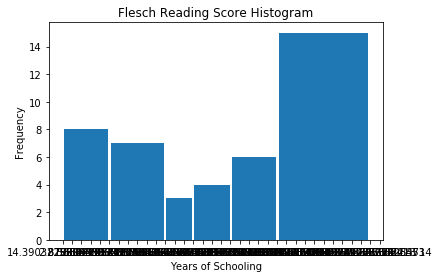

In [20]:
photos = Column_Headers(imagetags, hashtags, imageobjects, imagecolors)
DF = Readability_Data(fieldnames, photos)
frequency(DF)